# Practical 3: Transfer Learning

This is the second task of Practical 3. You will use transfer learning to build a convolutional neural network to tackle the CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). 
You could select an existing trained model (VGG16 excluded) from Keras (https://keras.io/api/applications/) and fine-tune it to solve the classification problem of CIFAR-10. 

We will mark your code based on the accuracy of your model. You should try to get **at least 80%** accuracy on this dataset. Don't forget to save and check in your model. 

## Import the libraries

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [86]:
tf.__version__

'2.3.0'

In [87]:
tf.keras.__version__

'2.4.0'

## Prepare the dataset

In this block, you will prepare the data for the training, such as apply the preprocess function of your selected model and perform data augmentation. 

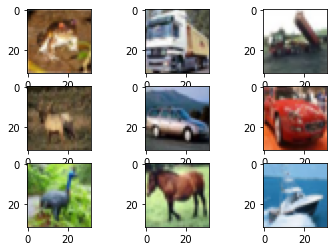

(50000, 32, 32, 3)

In [88]:
from keras.datasets import cifar10
from keras.applications.resnet import preprocess_input
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train_full[i])
plt.show()

X_train_full.shape

## Build and train the model

Build and train your model. 

In [89]:
#1H
y_train_full = keras.utils.to_categorical(y_train_full, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

#Validation
np.random.seed(1154)
validation_size = 10000 # we chose 20%
shuffled_indices = np.random.permutation(X_train_full.shape[0])
X_valid, X_train = X_train_full[shuffled_indices[:validation_size]], X_train_full[shuffled_indices[validation_size:]]
y_valid, y_train = y_train_full[shuffled_indices[:validation_size]], y_train_full[shuffled_indices[validation_size:]]

#Standardise
X_train = preprocess_input(X_train)
X_valid = preprocess_input(X_valid)
X_test = preprocess_input(X_test)

#Datagen
datagen = ImageDataGenerator(rotation_range=20, horizontal_flip=True, zoom_range=0.1)
datagen.fit(X_train)


In [90]:
resnet50_model = tf.keras.applications.resnet50.ResNet50(include_top=False, input_shape=(32, 32, 3), weights="imagenet", pooling="avg")
resnet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [91]:
#print(resnet50_model.layers[7].output)

In [92]:
x = resnet50_model.layers[-96].output
x = keras.layers.AveragePooling2D(pool_size=(2, 2), strides=None, padding="valid", data_format=None)(x)
x = keras.layers.BatchNormalization()(x) 
x = keras.layers.Flatten()(x) 
x = keras.layers.Dense(256, activation="relu")(x) 
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.3)(x) 
x = keras.layers.Dense(128, activation="relu")(x) 
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.3)(x)
output= keras.layers.Dense(units=10, activation="softmax")(x)
model = keras.Model(inputs=resnet50_model.input, outputs=output)

# Freezing
for layer in resnet50_model.layers[:19]:
    layer.trainable=False
for layer in resnet50_model.layers[19:]:
    layer.trainable=True

In [93]:
model.compile(optimizer=keras.optimizers.Adam(0.0001), 
             loss="categorical_crossentropy",
             metrics=["accuracy"])

In [94]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights = True)

train_data_generator = datagen.flow(X_train, y_train, batch_size=16)
history = model.fit(train_data_generator,
                    steps_per_epoch = len(X_train)/16,
                    epochs=20, 
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb])

Epoch 1/20
2500/2500 [==============================] - 167s 67ms/step - loss: 1.3796 - accuracy: 0.5498 - val_loss: 0.7858 - val_accuracy: 0.7372
Epoch 2/20
2500/2500 [==============================] - 165s 66ms/step - loss: 0.9572 - accuracy: 0.6782 - val_loss: 0.6819 - val_accuracy: 0.7763
Epoch 3/20
2500/2500 [==============================] - 164s 66ms/step - loss: 0.8181 - accuracy: 0.7242 - val_loss: 0.5833 - val_accuracy: 0.8074
Epoch 4/20
2500/2500 [==============================] - 165s 66ms/step - loss: 0.7355 - accuracy: 0.7508 - val_loss: 0.5477 - val_accuracy: 0.8108
Epoch 5/20
2500/2500 [==============================] - 164s 66ms/step - loss: 0.6824 - accuracy: 0.7703 - val_loss: 0.5102 - val_accuracy: 0.8298
Epoch 6/20
2500/2500 [==============================] - 169s 68ms/step - loss: 0.6315 - accuracy: 0.7886 - val_loss: 0.5221 - val_accuracy: 0.8211
Epoch 7/20
2500/2500 [==============================] - 168s 67ms/step - loss: 0.5905 - accuracy: 0.8014 - val_loss: 0

In [95]:
# show the structure of your model
model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________

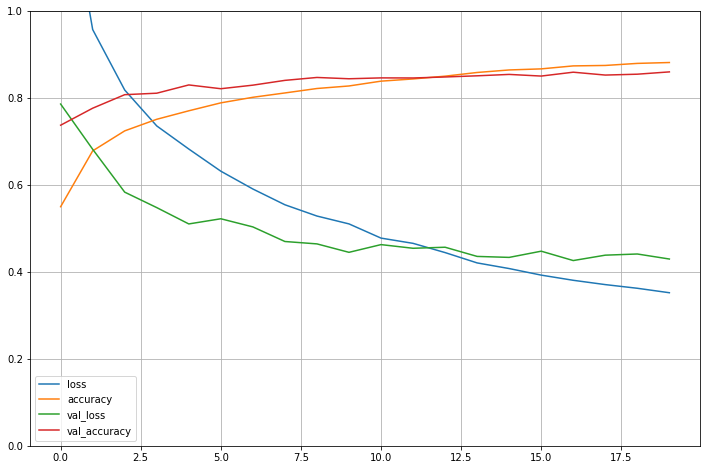

In [96]:
# Assume you have stored the training history in the variable "history"
# Show the learning curves
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.gca().set_ylim(0, 1)
plt.grid(True)
plt.show()

## Save the model

In [97]:
model.save('cifar10.h5') 

## Load the model and evaluate it on the test data

In [98]:
model = keras.models.load_model("cifar10.h5")
model.evaluate(X_test, y_test)

313/313 [==============================] - 8s 26ms/step - loss: 0.4586 - accuracy: 0.8540


[0.45861732959747314, 0.8539999723434448]

## Short report

Please write briefly how you build and train the model. Please include the decisions you made, such as how you decide the number of layers reused from the selected model, and the difficulties you met.

As our pretrained CNN, we chose ResNet50. We first used the whole ResNet50, froze all layers and added a flatten, two dense layers (256 and 128 neurons) and two dropout layers after ResNet50, which gave us a very low accuracy of 40%. We then realised that ResNet50 uses input of shape 224x224x3, but our input has shape 32x32x3, therefore we decided to cut off ResNet at the 4th convolution. Otherwise, the 5th and the 4th convolution would output 1x1x3 & 2x2x3, which does not make much sense in our eyes. We then unfroze the 3rd convolution, as we wanted to train some of ResNet50 layers. We then also added an MaxPooling before our dense layers to recognise the most significant features, but we then realised that in our case, AveragePooling perfomed better, so we chose AveragePooling. This gave us an accuracy that was close to 80%. We then played around a little bit with the Adam Optimizer and the size of the dropout layers, resulting in an 81% accuracy. In order to get a higher accuracy, we then startet to use ImageGenerator to get more diverse data, and adjusted the batch size from 32 to 16. We also unfroze more of ResNet50 (everything after the second convolution, second block, in order to only use the first part of ResNet, where more "sharp" features would be detected). This resulted in our final 85.42% accuracy. We chose 20 epochs, as earlier computations showed that after epoch 20, the validation loss stops decreasing, increasing our chances of overfitting.

We also tried models that were computationally way more expensive (see large_model.ipynb for the skeleton). There, we first scaled the 32x32x3 images so it would suit more the input ResNet50 is used toThe largest resultet in an accuracy of 90%, but it took nearly 20h to train only 3 epochs. Eventhough this model was way more accurate, we sticked to the model we present you in this file, as it reaches 85% with a running time of only 1 hour.